In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd "/content/drive/Shareddrives/DL Projet"

# Kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thamet","key":"711b8e184ff1e23e0f1ef33365bedcba"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

 99% 1.81G/1.82G [00:15<00:00, 133MB/s]
100% 1.82G/1.82G [00:15<00:00, 124MB/s]


# Chargement des données

In [ ]:
import zipfile

zip_file_name = "stanford-cars-dataset.zip"

extraction_path = "/content/drive/Shareddrives/DL Projet"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

FileNotFoundError: ignored

# Import

In [2]:
import os
from scipy.io import loadmat
import tqdm
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, models

# Dataset

## Variables

In [3]:
root_dir = "/content/drive/Shareddrives/DL Projet"
cars_annos = root_dir + "/cars_annos.mat"
cars_test = root_dir + "/cars_test/cars_test"
cars_train = root_dir + "/cars_train/cars_train"

In [4]:
cars_annos_mat = loadmat(cars_annos)
training_images = os.listdir(cars_train)
testing_images = os.listdir(cars_test)

In [5]:
class_names = [arr[0] for arr in cars_annos_mat['class_names'][0]]
num_classes = len(class_names)
print(num_classes)

196


In [6]:
cars_annos_train = root_dir + "/cars_train_annos.mat"
cars_annos_test = root_dir + "/cars_test_annos_withlabels.mat"

cars_annos_train_mat, cars_annos_test_mat = loadmat(cars_annos_train), loadmat(cars_annos_test)

In [7]:
training_image_label_dictionary, testing_image_label_dictionary = {}, {}

for arr in cars_annos_train_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    training_image_label_dictionary[image] = label

for arr in cars_annos_test_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    testing_image_label_dictionary[image] = label

print(len(training_image_label_dictionary), len(testing_image_label_dictionary))

8144 8041


## Dataset

In [8]:
class StanfordCarsDataset(Dataset):
    def __init__(self, directory, image_label_dict, transforms):
        super().__init__()

        self.images = [os.path.join(directory, f) for f in os.listdir(directory)]
        self.transforms = transforms
        self.image_label_dict = image_label_dict

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        img_pil = Image.open(image).convert('RGB')
        img_trans = self.transforms(img_pil)

        # Parse out the label from cars_meta and cars_x_annos files
        image_stem = image.split("/")[-1]
        img_label = self.image_label_dict[image_stem]

        return img_trans, img_label

In [9]:
def get_data(batch_size):
  mean = torch.tensor([0.4707, 0.4602, 0.4550])
  std = torch.tensor([0.2638, 0.2629, 0.2678])

  train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.RandomAdjustSharpness(sharpness_factor=2),
                                      transforms.RandomAutocontrast(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(degrees=35, translate=(0.3, 0.3)),
                                      transforms.Normalize(mean, std),
                                      ])

  test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224, 224)),
                                     transforms.Normalize(mean, std)])

  train_dataset = StanfordCarsDataset(cars_train, training_image_label_dictionary, train_transform)
  test_dataset = StanfordCarsDataset(cars_test, testing_image_label_dictionary, test_transform)

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

  return train_dataloader, test_dataloader

# Get

In [10]:
def get_cost_function():
  return nn.CrossEntropyLoss(label_smoothing=0.1)

In [11]:
def get_optimizer(model, lr, wd, momentum):
  return optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)

# Train et test

In [12]:
def train(model, data_loader, optimizer, cost_function, device="cuda"):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  model.train()

  data_loader = tqdm.tqdm(data_loader, total=len(data_loader), unit="batch")

  for (x,y) in data_loader:
    inputs, targets = x.to(device), y.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    outputs = outputs.to(device)

    loss = cost_function(outputs, targets)
    loss.backward()

    optimizer.step()

    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

In [13]:
def test(model, data_loader, cost_function, device="cuda"):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  model.eval()

  with torch.no_grad():
    data_loader = tqdm.tqdm(data_loader, total=len(data_loader), unit="batch")

    for (x,y) in data_loader:
      inputs, targets = x.to(device), y.to(device)

      outputs = model(inputs)
      outputs = outputs.to(device)

      loss = cost_function(outputs, targets)

      samples += inputs.shape[0]
      cumulative_loss += loss.item()
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

# Main

In [14]:
def main(model, batch_size=64, device="cuda", lr=0.01, wd=0.000001, momentum=0.9, epochs=1, name_model="model"):
  train_loader, test_loader = get_data(batch_size)

  optimizer = get_optimizer(model, lr, wd, momentum)

  cost_function = get_cost_function()

  for e in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, cost_function, device=device)

  print('After training:')
  train_loss, train_accuracy = test(model, train_loader, cost_function, device=device)
  test_loss, test_accuracy = test(model, test_loader, cost_function, device=device)

  print('\n')
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  path = "/content/drive/Shareddrives/DL Projet/" + name_model + ".pth"
  torch.save(model.state_dict(), path)

# Modèle 1

## Construction du modèle

In [ ]:
import torch
import torch.nn as nn
import torchvision

class Model1(nn.Module):
    def __init__(self, num_classes):
        super(Model1, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64*56*56, 128)
        self.fc2 = nn.Linear(128, self.num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))

        x = x.view(-1, 64*56*56)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Lancement du modèle

In [ ]:
model = Model1(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, name_model="model1")

## Optimisation des hyperparamètres

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'batch_size': [32, 64, 128],
    'momentum': [0.85, 0.9, 0.95],
    'wd': [1e-5, 1e-6, 1e-7]
}

grid = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_params = None

for params in grid:
    model = Model1(num_classes=num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loader, test_loader = get_data(params['batch_size'])

    # Mise à jour des paramètres
    optimizer = get_optimizer(model, lr=0.01, wd=params['wd'], momentum=params['momentum'])
    cost_function = get_cost_function()

    for e in range(1):
      train_loss, train_accuracy = train(model, train_loader, optimizer, cost_function, device=device)

    print('After training:')
    train_loss, train_accuracy = test(model, train_loader, cost_function, device=device)
    test_loss, test_accuracy = test(model, test_loader, cost_function, device=device)

    print('\n')
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
    print('\t Batch size: {}'.format(params['batch_size']))
    print('\t Momentum: {}'.format(params['momentum']))
    print('\t Weight decay: {}'.format(params['wd']))
    print('-----------------------------------------------------')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

  0%|          | 0/128 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 128/128 [06:00<00:00,  2.81s/batch]


After training:


 41%|████▏     | 52/126 [16:50<23:57, 19.43s/batch]


UnidentifiedImageError: ignored

### Changement d'epochs

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'epochs': [1, 5, 10]
}

grid = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_params = None

for params in grid:
    model = Model1(num_classes=num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loader, test_loader = get_data(32)

    # Mise à jour des paramètres
    optimizer = get_optimizer(model, lr=0.01, wd=1e-7, momentum=0.9)
    cost_function = get_cost_function()

    for e in range(params['epochs']):
      train_loss, train_accuracy = train(model, train_loader, optimizer, cost_function, device=device)

    print('After training:')
    train_loss, train_accuracy = test(model, train_loader, cost_function, device=device)
    test_loss, test_accuracy = test(model, test_loader, cost_function, device=device)

    print('\n')
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

  0%|          | 0/255 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 255/255 [03:37<00:00,  1.17batch/s]


After training:


100%|██████████| 252/252 [48:39<00:00, 11.59s/batch]




	 Training loss 0.16023, Training accuracy 2.22
	 Test loss 0.16080, Test accuracy 2.21
-----------------------------------------------------


100%|██████████| 255/255 [03:23<00:00,  1.25batch/s]


After training:


100%|██████████| 252/252 [02:24<00:00,  1.75batch/s]



	 Training loss 0.15874, Training accuracy 2.69
	 Test loss 0.16033, Test accuracy 2.24
-----------------------------------------------------
Best Parameters: {'epochs': 10}
Best Accuracy: 2.238527546325084


### Identification du meilleur lr

In [ ]:
pip install torch-lr-finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.52E-03


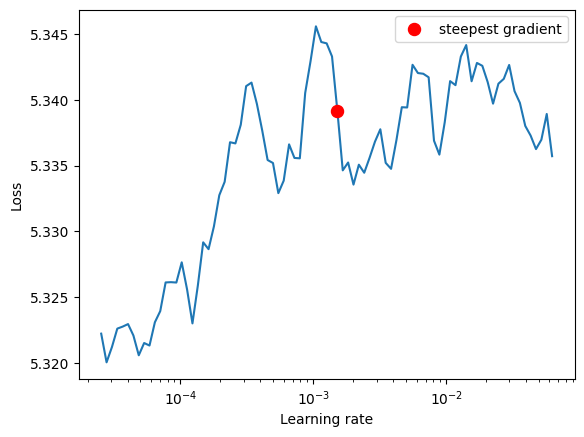

In [ ]:
from torch_lr_finder import LRFinder

train_loader, _ = get_data(batch_size=64)

model = Model1(num_classes)
model.load_state_dict(torch.load("/content/drive/Shareddrives/DL Projet/model1.pth"))
optimizer = get_optimizer(model, lr=1e-5, wd=1e-6, momentum=0.95)
cost_function = get_cost_function()

# Utiliser le LR Finder pour trouver le taux d'apprentissage optimal
lr_finder = LRFinder(model, optimizer, cost_function, device="cuda")
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot()  # Plot the loss versus learning rate
lr_finder.reset()

In [ ]:
model = Model1(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=64, lr=1e-1, wd=1e-6, momentum=0.95, epochs=10, name_model="model1")

100%|██████████| 128/128 [03:08<00:00,  1.47s/batch]


After training:


100%|██████████| 126/126 [02:15<00:00,  1.08s/batch]




	 Training loss 0.08289, Training accuracy 0.83
	 Test loss 0.08264, Test accuracy 0.85
-----------------------------------------------------


In [ ]:
model = Model1(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=64, lr=1e-3, wd=1e-6, momentum=0.95, epochs=10, name_model="model1")

100%|██████████| 128/128 [03:09<00:00,  1.48s/batch]


After training:


100%|██████████| 126/126 [59:50<00:00, 28.49s/batch]




	 Training loss 0.08295, Training accuracy 0.83
	 Test loss 0.08270, Test accuracy 0.85
-----------------------------------------------------


In [ ]:
model = Model1(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=64, lr=1.52e-3, wd=1e-6, momentum=0.95, epochs=10, name_model="model1")

  0%|          | 0/128 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 128/128 [03:40<00:00,  1.73s/batch]


After training:


100%|██████████| 126/126 [44:56<00:00, 21.40s/batch]




	 Training loss 0.08130, Training accuracy 1.65
	 Test loss 0.08112, Test accuracy 1.24
-----------------------------------------------------


## Affichage des prédictions

In [ ]:
model = Model1(num_classes)
model.load_state_dict(torch.load("/content/drive/Shareddrives/DL Projet/model1.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
import matplotlib.pyplot as plt

model.eval()
_, test_loader = get_data(batch_size=64)

with torch.no_grad():
  inputs, targets = next(iter(test_loader))
  outputs = model(inputs)
  _, predicted = torch.max(outputs, 1)

  print(predicted)


w, h = 4, 8
fig, axes_list = plt.subplots(h, w, figsize=(25, 40))
fig.suptitle('Inference on one batch')

axes_list = axes_list.flatten()

for i in range(min(len(inputs), w * h)):
    axes_list[i].imshow(inputs[i].permute(1, 2, 0))
    axes_list[i].axis('off')
    axes_list[i].set(title=f"Actual: {class_names[targets[i] - 1]}\n Predicted: {class_names[predicted[i] - 1]}")

# Assurez-vous de ne pas afficher les sous-plots inutilisés
for i in range(len(imgs), w * h):
    fig.delaxes(axes_list[i])

plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Modèle 2

## Construction du modèle

In [15]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class Model2(nn.Module):
  def __init__(self, num_classes):
    super(Model2, self).__init__()
    self.num_classes = num_classes

    self.resnet = resnet50(pretrained=True)

    for param in self.resnet.parameters():
      param.requires_grad = False

    num_features = self.resnet.fc.in_features
    self.resnet.fc = nn.Sequential(
      nn.Linear(num_features, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),
      nn.Dropout(0.5),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.BatchNorm1d(512),
      nn.Dropout(0.5),
      nn.Linear(512, self.num_classes)
    )

  def forward(self, x):
    return self.resnet(x)

## Lancement du modèle

In [ ]:
model = Model2(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, name_model="model2")

100%|██████████| 128/128 [03:35<00:00,  1.68s/batch]


After training:


100%|██████████| 126/126 [47:02<00:00, 22.40s/batch]




	 Training loss 0.06664, Training accuracy 14.17
	 Test loss 0.06755, Test accuracy 10.88
-----------------------------------------------------


## Changement d'optimizer

### Adam

In [ ]:
def get_optimizer(model, lr, wd, momentum):
  return optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
model = Model2(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=32, wd=1e-4, momentum=0.85, name_model="model2")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/255 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warnin

After training:


100%|██████████| 252/252 [53:00<00:00, 12.62s/batch]




	 Training loss 0.13932, Training accuracy 9.59
	 Test loss 0.13925, Test accuracy 7.75
-----------------------------------------------------


### RMSProp

In [ ]:
def get_optimizer(model, lr, wd, momentum):
  return optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)

In [ ]:
model = Model2(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=32, wd=1e-4, momentum=0.85, name_model="model2")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/255 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warnin

## Changement de loss function

###Focal Loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.cross_entropy(inputs, targets, reduce=False)
        else:
            BCE_loss = F.cross_entropy(F.log_softmax(inputs, dim=1), targets, reduce=False)

        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(focal_loss)
        else:
            return focal_loss

def get_cost_function():
  return FocalLoss()

In [ ]:
model = Model2(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=32, lr=2.98e-2, wd=1e-4, momentum=0.85, epochs=1, name_model="model2")

100%|██████████| 255/255 [03:41<00:00,  1.15batch/s]


After training:


100%|██████████| 252/252 [54:16<00:00, 12.92s/batch]




	 Training loss 0.12299, Training accuracy 11.47
	 Test loss 0.12824, Test accuracy 9.95
-----------------------------------------------------


### MSE Loss

In [ ]:
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()

    def forward(self, predictions, targets):
        # Ajustez les dimensions des prédictions si nécessaire
        predictions = predictions.squeeze()

        # Transposez les dimensions des prédictions pour correspondre à celles des cibles
        predictions = predictions.t()

        # Convertissez les prédictions en float si elles ne le sont pas déjà
        predictions = predictions.float()

        loss = nn.MSELoss(reduction='mean')(predictions, targets.float())
        return loss

def get_cost_function():
  return CustomMSELoss()

In [ ]:
model = Model2(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=32, lr=2.98e-2, wd=1e-4, momentum=0.85, epochs=2, name_model="model2")

100%|██████████| 255/255 [03:36<00:00,  1.18batch/s]


After training:


100%|██████████| 252/252 [02:42<00:00,  1.55batch/s]




	 Training loss nan, Training accuracy 0.55
	 Test loss nan, Test accuracy 0.55
-----------------------------------------------------


## Optimisation des hyperparamètres

### Batch_size, momentum, weight_decay

test : batch size = 32, momentum = 0.85, wd = 1e-04

---



In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'batch_size': [16, 32, 64, 128],
    'momentum': [0.8, 0.85, 0.9, 0.95],
    'wd': [1e-4, 1e-5, 1e-6, 1e-7]
}


grid = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_params = None

for params in grid:
    model = Model2(num_classes=num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loader, test_loader = get_data(params['batch_size'])

    # Mise à jour des paramètres
    optimizer = get_optimizer(model, lr=0.01, wd=params['wd'], momentum=params['momentum'])
    cost_function = get_cost_function()

    for e in range(1):
      train_loss, train_accuracy = train(model, train_loader, optimizer, cost_function, device=device)

    print('After training:')
    train_loss, train_accuracy = test(model, train_loader, cost_function, device=device)
    test_loss, test_accuracy = test(model, test_loader, cost_function, device=device)

    print('\n')
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
    print('\t Batch size: {}'.format(params['batch_size']))
    print('\t Momentum: {}'.format(params['momentum']))
    print('\t Weight decay: {}'.format(params['wd']))
    print('-----------------------------------------------------')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/509 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warnin

After training:


100%|██████████| 503/503 [02:47<00:00,  3.01batch/s]




	 Training loss 0.26978, Training accuracy 12.38
	 Test loss 0.27543, Test accuracy 9.65
-----------------------------------------------------
	 Batch size: 16
	 Momentum: 0.8
	 Weight decay: 0.0001
-----------------------------------------------------


100%|██████████| 509/509 [03:43<00:00,  2.27batch/s]


After training:


100%|██████████| 503/503 [02:53<00:00,  2.90batch/s]




	 Training loss 0.26870, Training accuracy 12.36
	 Test loss 0.27217, Test accuracy 10.05
-----------------------------------------------------
	 Batch size: 16
	 Momentum: 0.8
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 509/509 [03:50<00:00,  2.21batch/s]


After training:


100%|██████████| 503/503 [02:55<00:00,  2.87batch/s]




	 Training loss 0.27025, Training accuracy 11.75
	 Test loss 0.27767, Test accuracy 9.29
-----------------------------------------------------
	 Batch size: 16
	 Momentum: 0.85
	 Weight decay: 0.0001
-----------------------------------------------------


100%|██████████| 509/509 [03:40<00:00,  2.31batch/s]


After training:


100%|██████████| 503/503 [02:50<00:00,  2.94batch/s]




	 Training loss 0.27023, Training accuracy 11.80
	 Test loss 0.27302, Test accuracy 10.71
-----------------------------------------------------
	 Batch size: 16
	 Momentum: 0.85
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 255/255 [03:31<00:00,  1.20batch/s]


After training:


100%|██████████| 252/252 [02:39<00:00,  1.58batch/s]




	 Training loss 0.13308, Training accuracy 13.65
	 Test loss 0.13469, Test accuracy 11.16
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.8
	 Weight decay: 0.0001
-----------------------------------------------------


100%|██████████| 255/255 [03:34<00:00,  1.19batch/s]


After training:


100%|██████████| 252/252 [02:39<00:00,  1.58batch/s]




	 Training loss 0.13363, Training accuracy 13.80
	 Test loss 0.13528, Test accuracy 11.02
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.8
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 255/255 [03:31<00:00,  1.20batch/s]


After training:


100%|██████████| 252/252 [02:39<00:00,  1.58batch/s]




	 Training loss 0.13213, Training accuracy 13.59
	 Test loss 0.13368, Test accuracy 11.68
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.85
	 Weight decay: 0.0001
-----------------------------------------------------


100%|██████████| 255/255 [03:32<00:00,  1.20batch/s]


After training:


100%|██████████| 252/252 [02:36<00:00,  1.61batch/s]



	 Training loss 0.13176, Training accuracy 13.36
	 Test loss 0.13343, Test accuracy 10.81
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.85
	 Weight decay: 1e-05
-----------------------------------------------------
Best Parameters: {'batch_size': 32, 'momentum': 0.85, 'wd': 0.0001}
Best Accuracy: 11.677652033329187


### Optimisation du nombre d'epochs

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'epochs': [30]
}

grid = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_params = None

for params in grid:
    model = Model2(num_classes=num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loader, test_loader = get_data(32)

    # Mise à jour des paramètres
    optimizer = get_optimizer(model, lr=0.01, wd=1e-7, momentum=0.9)
    cost_function = get_cost_function()

    for e in range(params['epochs']):
      train_loss, train_accuracy = train(model, train_loader, optimizer, cost_function, device=device)

    print('After training:')
    train_loss, train_accuracy = test(model, train_loader, cost_function, device=device)
    test_loss, test_accuracy = test(model, test_loader, cost_function, device=device)

    print('\n')
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

100%|██████████| 255/255 [03:27<00:00,  1.23batch/s]


After training:


100%|██████████| 252/252 [02:39<00:00,  1.58batch/s]



	 Training loss 0.08883, Training accuracy 47.48
	 Test loss 0.10118, Test accuracy 33.45
-----------------------------------------------------
Best Parameters: {'epochs': 30}
Best Accuracy: 33.453550553413756


### Identification du meilleur lr

In [ ]:
pip install torch-lr-finder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.98E-02


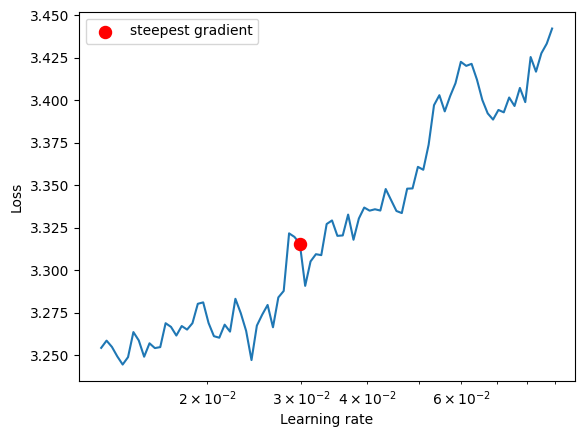

In [ ]:
from torch_lr_finder import LRFinder

train_loader, _ = get_data(batch_size=64)

model = Model2(num_classes)
model.load_state_dict(torch.load("/content/drive/Shareddrives/DL Projet/model2.pth"))
optimizer = get_optimizer(model, lr=0.01, wd=1e-5, momentum=0.85)
cost_function = get_cost_function()

# Utiliser le LR Finder pour trouver le taux d'apprentissage optimal
lr_finder = LRFinder(model, optimizer, cost_function, device="cuda")
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot()  # Plot the loss versus learning rate
lr_finder.reset()

In [16]:
model = Model2(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=32, lr=2.98e-2, wd=1e-4, momentum=0.85, epochs=20, name_model="model2")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.5MB/s]
  0%|          | 0/255 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all t

After training:


100%|██████████| 252/252 [1:06:31<00:00, 15.84s/batch]




	 Training loss 0.09473, Training accuracy 42.06
	 Test loss 0.10427, Test accuracy 31.13
-----------------------------------------------------


## Affichage des predictions

In [ ]:
model = Model2(num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/drive/Shareddrives/DL Projet/model2.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model.eval()
_, test_loader = get_data(batch_size=64)

with torch.no_grad():
  imgs, labels = next(iter(test_loader))
  inputs, labels = imgs.cuda(), labels.cuda()
  outputs = model(inputs)
  _, predicted = torch.max(outputs, 1)

  print(predicted)

cuda_tensor = torch.tensor(predicted, device='cuda:0')

# Move the tensor to the CPU
cpu_tensor = cuda_tensor.cpu()

# Convert the CPU tensor to a NumPy array
predicted_lab = cpu_tensor.numpy()

print(accuracy_score(labels, predicted_lab))

w, h = 4, 8
fig, axes_list = plt.subplots(h, w, figsize=(25, 40))
fig.suptitle('Inference on one batch')

axes_list = axes_list.flatten()

for i in range(min(len(imgs), w * h)):
    axes_list[i].imshow(imgs[i].permute(1, 2, 0))
    axes_list[i].axis('off')
    axes_list[i].set(title=f"Actual: {class_names[labels[i] - 1]}\n Predicted: {class_names[predicted[i] - 1]}")

# Assurez-vous de ne pas afficher les sous-plots inutilisés
for i in range(len(imgs), w * h):
    fig.delaxes(axes_list[i])

plt.show()

# Modèle 3

## Construction du modèle

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.resnet import Bottleneck
from torchvision.models.resnet import conv1x1

class Bottle2Neck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, scales=4):
        super(Bottle2Neck, self).__init__()
        width = int(planes * (scales / 32.))
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=scales, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * 4)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride


    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Res2Net(nn.Module):
    def __init__(self, block, layers, num_classes=196):
        super(Res2Net, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], scales=4)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, scales=4)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, scales=4)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, scales=4)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, scales=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, scales))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, scales=scales))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def Res2Net50():
    layers = [3, 4, 6, 3]
    model = Res2Net(Bottle2Neck, layers)
    return model


class Model3(nn.Module):
    def __init__(self, num_classes):
        super(Model3, self).__init__()

        self.res2net = Res2Net50()
        self.num_classes = num_classes

        for param in self.res2net.parameters():
            param.requires_grad = False

        num_features = self.res2net.fc.in_features
        self.res2net.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x):
        return self.res2net(x)

## Lancement du modèle

In [ ]:
model = Model3(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, name_model="model3")

100%|██████████| 128/128 [03:43<00:00,  1.75s/batch]


After training:


100%|██████████| 126/126 [40:01<00:00, 19.06s/batch]




	 Training loss 0.08513, Training accuracy 0.66
	 Test loss 0.08391, Test accuracy 0.65
-----------------------------------------------------


### Optimisation des hyperparamètres

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'batch_size': [32, 64, 128],
    'momentum': [0.9, 0.95],
    'wd': [1e-5, 1e-6, 1e-7]
}

grid = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_params = None

for params in grid:
    model = Model3(num_classes=num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loader, test_loader = get_data(params['batch_size'])

    # Mise à jour des paramètres
    optimizer = get_optimizer(model, lr=0.01, wd=params['wd'], momentum=params['momentum'])
    cost_function = get_cost_function()

    for e in range(1):
      train_loss, train_accuracy = train(model, train_loader, optimizer, cost_function, device=device)

    print('After training:')
    train_loss, train_accuracy = test(model, train_loader, cost_function, device=device)
    test_loss, test_accuracy = test(model, test_loader, cost_function, device=device)

    print('\n')
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
    print('\t Batch size: {}'.format(params['batch_size']))
    print('\t Momentum: {}'.format(params['momentum']))
    print('\t Weight decay: {}'.format(params['wd']))
    print('-----------------------------------------------------')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

  0%|          | 0/255 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 255/255 [05:58<00:00,  1.41s/batch]


After training:


100%|██████████| 252/252 [44:08<00:00, 10.51s/batch]




	 Training loss 0.17559, Training accuracy 0.48
	 Test loss 0.17651, Test accuracy 0.45
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.9
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 255/255 [03:27<00:00,  1.23batch/s]


After training:


100%|██████████| 252/252 [02:36<00:00,  1.61batch/s]




	 Training loss 0.17636, Training accuracy 0.66
	 Test loss 0.17446, Test accuracy 0.76
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.9
	 Weight decay: 1e-06
-----------------------------------------------------


100%|██████████| 255/255 [03:31<00:00,  1.20batch/s]


After training:


100%|██████████| 252/252 [02:38<00:00,  1.59batch/s]




	 Training loss 0.17520, Training accuracy 0.50
	 Test loss 0.17165, Test accuracy 0.50
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.9
	 Weight decay: 1e-07
-----------------------------------------------------


100%|██████████| 255/255 [03:32<00:00,  1.20batch/s]


After training:


100%|██████████| 252/252 [02:33<00:00,  1.64batch/s]




	 Training loss 0.18520, Training accuracy 0.65
	 Test loss 0.18052, Test accuracy 0.53
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.95
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 255/255 [03:26<00:00,  1.23batch/s]


After training:


100%|██████████| 252/252 [02:34<00:00,  1.63batch/s]




	 Training loss 0.18528, Training accuracy 0.53
	 Test loss 0.18063, Test accuracy 0.35
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.95
	 Weight decay: 1e-06
-----------------------------------------------------


100%|██████████| 255/255 [03:30<00:00,  1.21batch/s]


After training:


100%|██████████| 252/252 [02:30<00:00,  1.67batch/s]




	 Training loss 0.18240, Training accuracy 0.68
	 Test loss 0.18068, Test accuracy 0.61
-----------------------------------------------------
	 Batch size: 32
	 Momentum: 0.95
	 Weight decay: 1e-07
-----------------------------------------------------


100%|██████████| 128/128 [03:22<00:00,  1.58s/batch]


After training:


100%|██████████| 126/126 [02:32<00:00,  1.21s/batch]




	 Training loss 0.08518, Training accuracy 0.83
	 Test loss 0.08381, Test accuracy 0.66
-----------------------------------------------------
	 Batch size: 64
	 Momentum: 0.9
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 128/128 [03:25<00:00,  1.60s/batch]


After training:


100%|██████████| 126/126 [02:32<00:00,  1.21s/batch]




	 Training loss 0.08527, Training accuracy 0.58
	 Test loss 0.08501, Test accuracy 0.61
-----------------------------------------------------
	 Batch size: 64
	 Momentum: 0.9
	 Weight decay: 1e-06
-----------------------------------------------------


100%|██████████| 128/128 [03:19<00:00,  1.56s/batch]


After training:


100%|██████████| 126/126 [02:28<00:00,  1.18s/batch]




	 Training loss 0.08605, Training accuracy 0.72
	 Test loss 0.08525, Test accuracy 0.66
-----------------------------------------------------
	 Batch size: 64
	 Momentum: 0.9
	 Weight decay: 1e-07
-----------------------------------------------------


100%|██████████| 128/128 [03:30<00:00,  1.64s/batch]


After training:


100%|██████████| 126/126 [02:22<00:00,  1.13s/batch]




	 Training loss 0.08776, Training accuracy 0.64
	 Test loss 0.08594, Test accuracy 0.63
-----------------------------------------------------
	 Batch size: 64
	 Momentum: 0.95
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 128/128 [03:31<00:00,  1.65s/batch]


After training:


100%|██████████| 126/126 [02:26<00:00,  1.16s/batch]




	 Training loss 0.08864, Training accuracy 0.50
	 Test loss 0.08691, Test accuracy 0.49
-----------------------------------------------------
	 Batch size: 64
	 Momentum: 0.95
	 Weight decay: 1e-06
-----------------------------------------------------


100%|██████████| 128/128 [03:32<00:00,  1.66s/batch]


After training:


100%|██████████| 126/126 [02:26<00:00,  1.16s/batch]




	 Training loss 0.08773, Training accuracy 0.74
	 Test loss 0.08574, Test accuracy 0.52
-----------------------------------------------------
	 Batch size: 64
	 Momentum: 0.95
	 Weight decay: 1e-07
-----------------------------------------------------


100%|██████████| 64/64 [03:16<00:00,  3.07s/batch]


After training:


100%|██████████| 63/63 [02:28<00:00,  2.35s/batch]




	 Training loss 0.04182, Training accuracy 0.61
	 Test loss 0.04186, Test accuracy 0.52
-----------------------------------------------------
	 Batch size: 128
	 Momentum: 0.9
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 64/64 [03:21<00:00,  3.15s/batch]


After training:


100%|██████████| 63/63 [02:25<00:00,  2.31s/batch]




	 Training loss 0.04230, Training accuracy 0.56
	 Test loss 0.04248, Test accuracy 0.60
-----------------------------------------------------
	 Batch size: 128
	 Momentum: 0.9
	 Weight decay: 1e-06
-----------------------------------------------------


100%|██████████| 64/64 [03:16<00:00,  3.07s/batch]


After training:


100%|██████████| 63/63 [02:26<00:00,  2.32s/batch]




	 Training loss 0.04191, Training accuracy 0.86
	 Test loss 0.04193, Test accuracy 0.75
-----------------------------------------------------
	 Batch size: 128
	 Momentum: 0.9
	 Weight decay: 1e-07
-----------------------------------------------------


100%|██████████| 64/64 [03:17<00:00,  3.09s/batch]


After training:


100%|██████████| 63/63 [02:27<00:00,  2.34s/batch]




	 Training loss 0.04247, Training accuracy 0.72
	 Test loss 0.04241, Test accuracy 0.66
-----------------------------------------------------
	 Batch size: 128
	 Momentum: 0.95
	 Weight decay: 1e-05
-----------------------------------------------------


100%|██████████| 64/64 [03:13<00:00,  3.03s/batch]


After training:


100%|██████████| 63/63 [02:28<00:00,  2.35s/batch]




	 Training loss 0.04226, Training accuracy 0.75
	 Test loss 0.04234, Test accuracy 0.67
-----------------------------------------------------
	 Batch size: 128
	 Momentum: 0.95
	 Weight decay: 1e-06
-----------------------------------------------------


100%|██████████| 64/64 [03:21<00:00,  3.14s/batch]


After training:


100%|██████████| 63/63 [02:25<00:00,  2.31s/batch]



	 Training loss 0.04259, Training accuracy 0.75
	 Test loss 0.04238, Test accuracy 0.90
-----------------------------------------------------
	 Batch size: 128
	 Momentum: 0.95
	 Weight decay: 1e-07
-----------------------------------------------------
Best Parameters: {'batch_size': 128, 'momentum': 0.95, 'wd': 1e-07}
Best Accuracy: 0.8954110185300336


### Optimisation du nombre d'epochs

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'epochs': [1, 5, 10]
}

grid = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_params = None

for params in grid:
    model = Model3(num_classes=num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loader, test_loader = get_data(128)

    # Mise à jour des paramètres
    optimizer = get_optimizer(model, lr=0.01, wd=1e-7, momentum=0.9)
    cost_function = get_cost_function()

    for e in range(params['epochs']):
      train_loss, train_accuracy = train(model, train_loader, optimizer, cost_function, device=device)

    print('After training:')
    train_loss, train_accuracy = test(model, train_loader, cost_function, device=device)
    test_loss, test_accuracy = test(model, test_loader, cost_function, device=device)

    print('\n')
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

  0%|          | 0/64 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 64/64 [05:49<00:00,  5.46s/batch]


After training:


100%|██████████| 63/63 [41:36<00:00, 39.63s/batch]




	 Training loss 0.04183, Training accuracy 0.82
	 Test loss 0.04220, Test accuracy 0.61
-----------------------------------------------------


100%|██████████| 64/64 [03:12<00:00,  3.01s/batch]


After training:


100%|██████████| 63/63 [02:27<00:00,  2.35s/batch]




	 Training loss 0.04183, Training accuracy 0.71
	 Test loss 0.04165, Test accuracy 0.60
-----------------------------------------------------


100%|██████████| 64/64 [03:15<00:00,  3.05s/batch]


After training:


100%|██████████| 63/63 [02:29<00:00,  2.38s/batch]



	 Training loss 0.04170, Training accuracy 0.65
	 Test loss 0.04150, Test accuracy 0.71
-----------------------------------------------------
Best Parameters: {'epochs': 10}
Best Accuracy: 0.7088670563362767


### Identification du meilleur lr

In [ ]:
pip install torch-lr-finder

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.45E-02


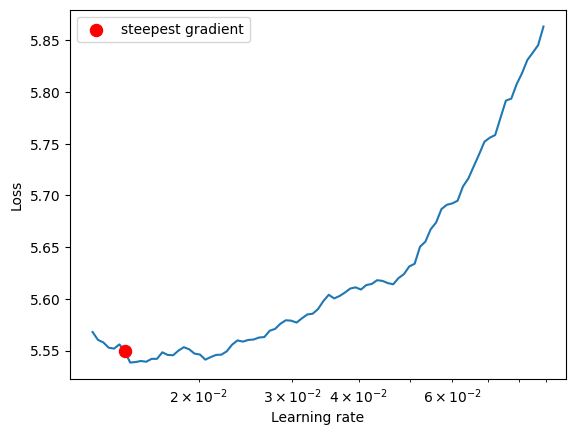

In [ ]:
from torch_lr_finder import LRFinder

train_loader, _ = get_data(batch_size=128)

model = Model3(num_classes=num_classes)
model.load_state_dict(torch.load("/content/drive/Shareddrives/DL Projet/model3.pth"))
optimizer = get_optimizer(model, lr=0.01, wd=1e-7, momentum=0.9)
cost_function = get_cost_function()

# Utiliser le LR Finder pour trouver le taux d'apprentissage optimal
lr_finder = LRFinder(model, optimizer, cost_function, device="cuda")
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot()  # Plot the loss versus learning rate
lr_finder.reset()

In [ ]:
model = Model3(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

main(model=model, device=device, batch_size=128, lr=1.45e-2, wd=1e-7, momentum=0.9, epochs=10, name_model="model3")

  0%|          | 0/64 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 64/64 [03:10<00:00,  2.97s/batch]


After training:


 40%|███▉      | 25/63 [44:33<1:07:43, 106.93s/batch]


KeyboardInterrupt: ignored

## Affichage des predictions

tensor([192,  45,   2, 109, 103,  67, 147,  27, 152,  11, 118, 154, 122, 192,
        125,  40,   2, 128,  98, 154, 152,  23,  26, 165,  17,  72, 138,  24,
        130, 144, 157, 110, 177,  48, 160, 130, 161,  48,  29, 172, 125,  37,
         53, 152,  43, 124,  18, 186,  27, 156,  43,  21, 161, 164,  79,  80,
          8,  51,  18,  54,  10, 172, 153,  65], device='cuda:0')


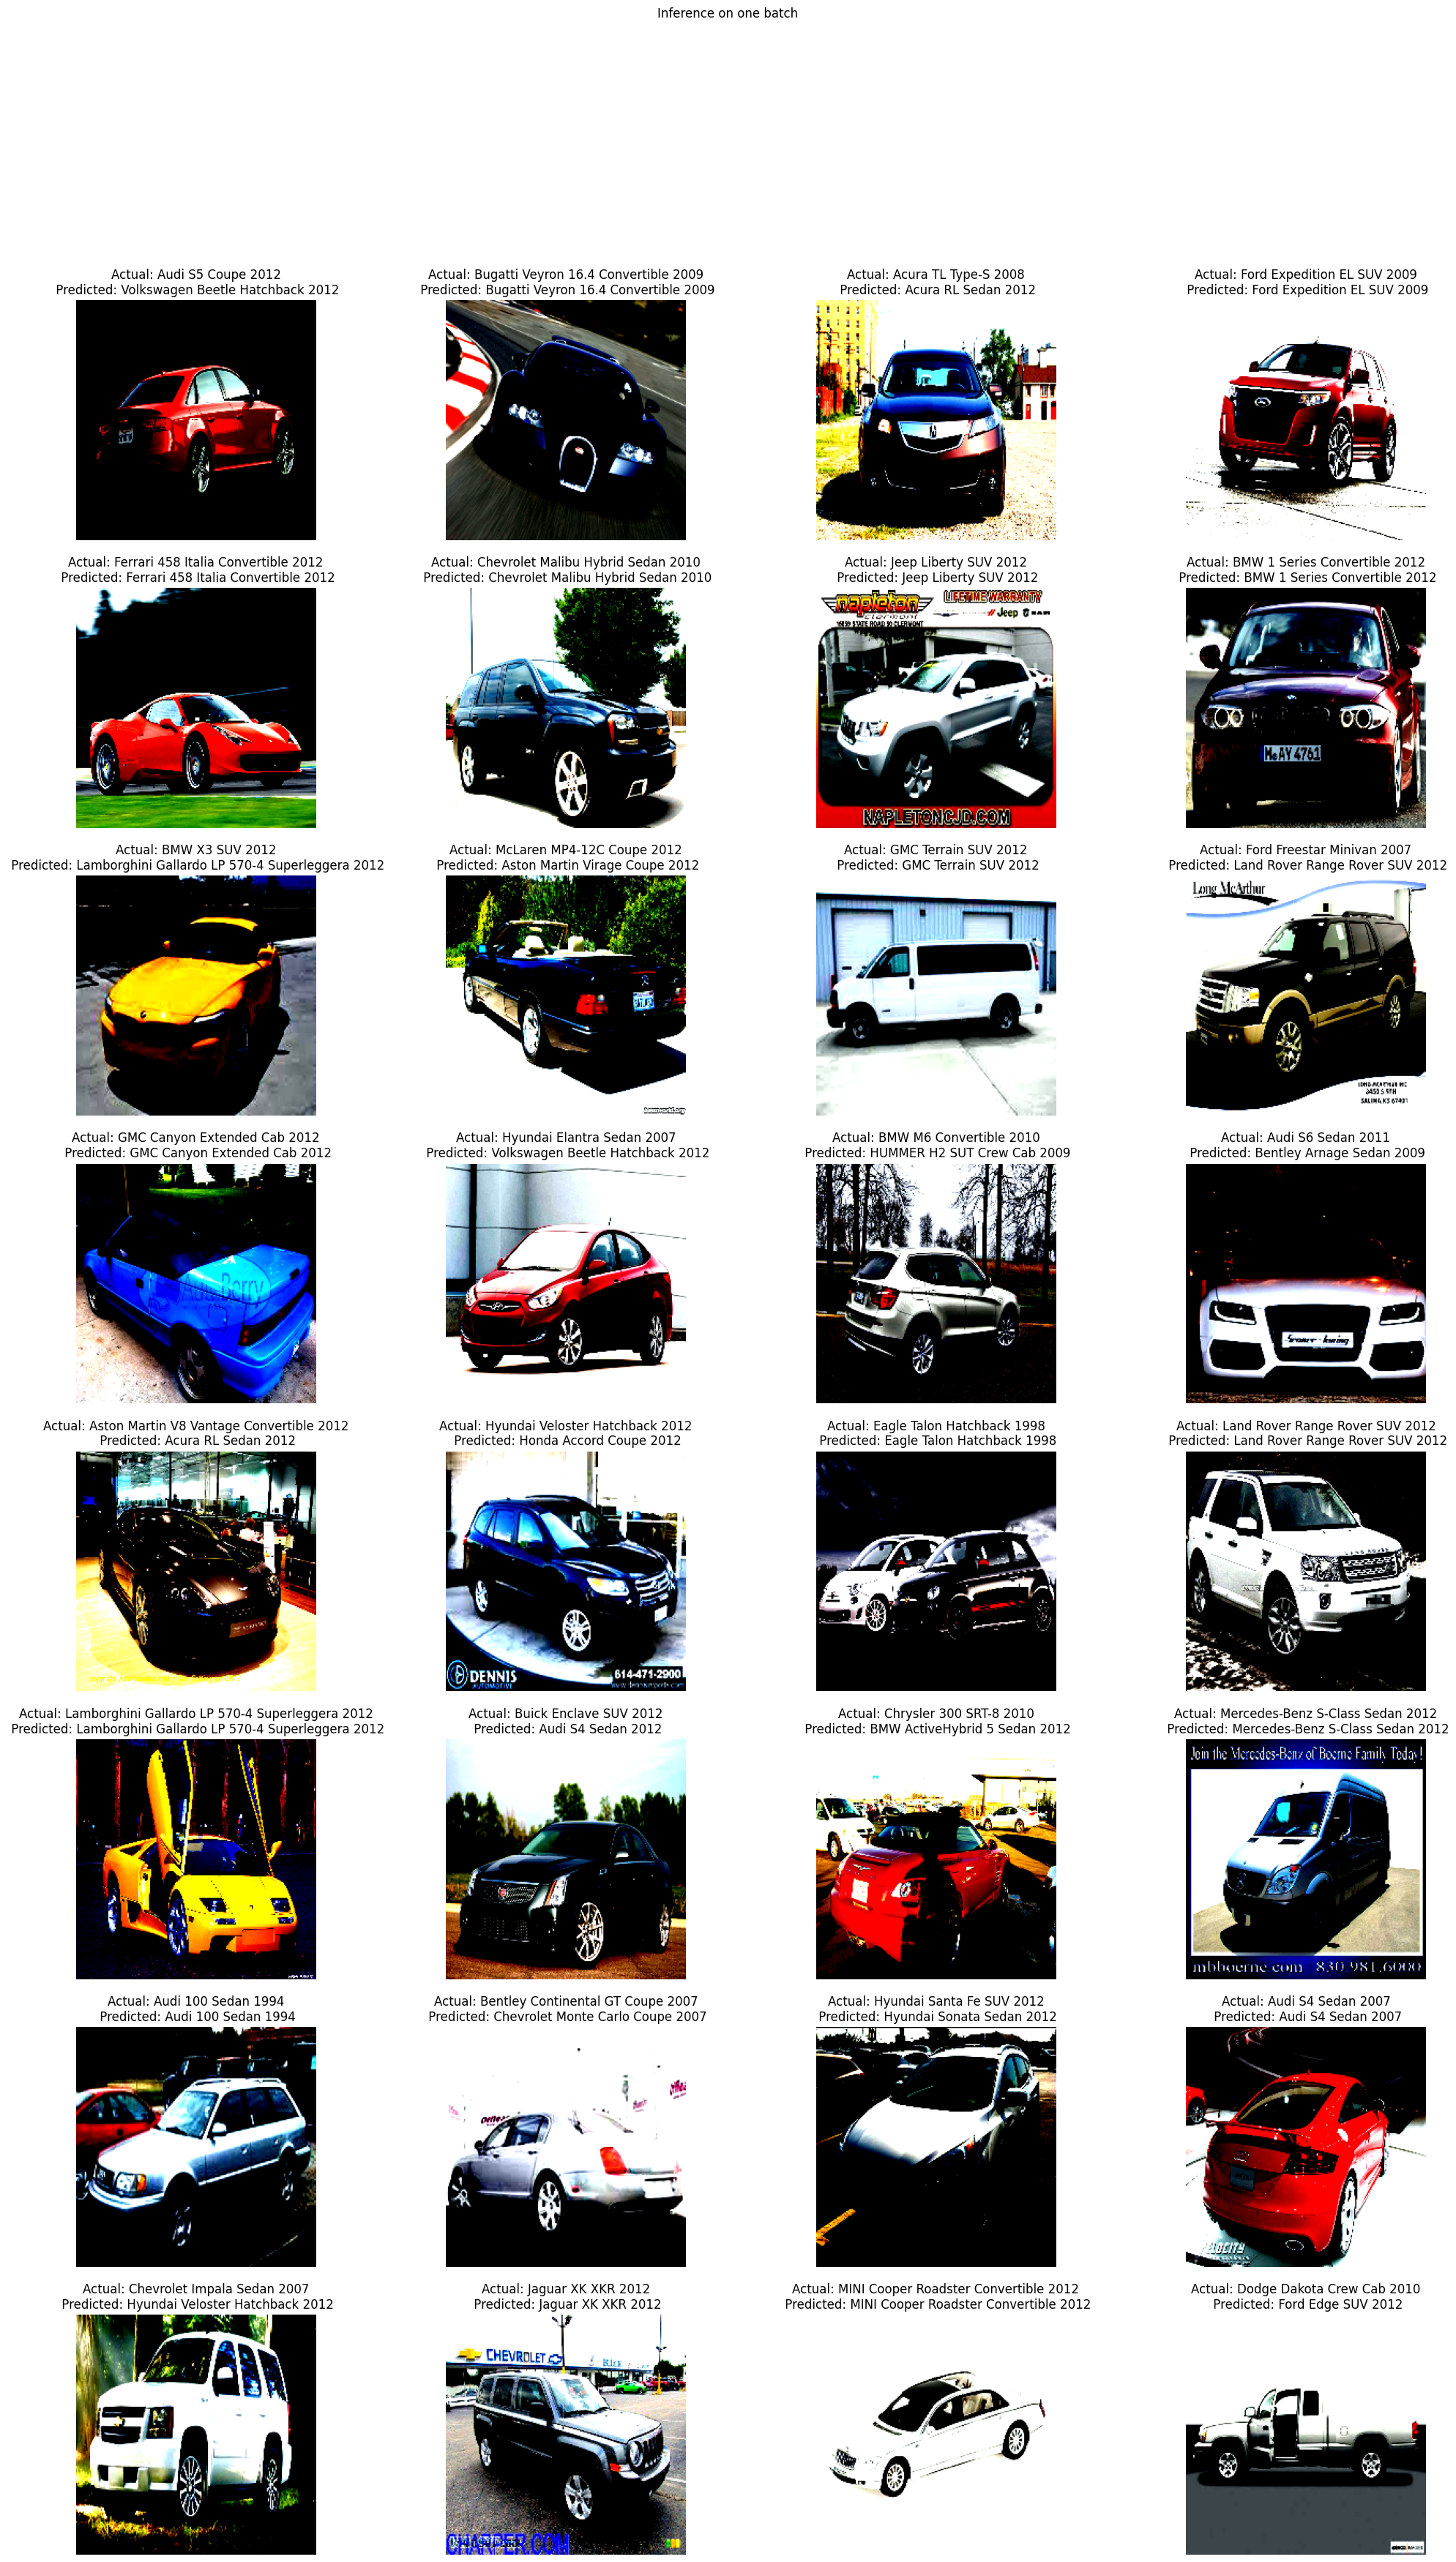

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model.eval()
_, test_loader = get_data(batch_size=64)

with torch.no_grad():
  imgs, labels = next(iter(test_loader))
  inputs, labels = imgs.cuda(), labels.cuda()
  outputs = model(inputs)
  _, predicted = torch.max(outputs, 1)

  print(predicted)

cuda_tensor = torch.tensor(predicted, device='cuda:0')

# Move the tensor to the CPU
cpu_tensor = cuda_tensor.cpu()

# Convert the CPU tensor to a NumPy array
predicted_lab = cpu_tensor.numpy()

print(accuracy_score(labels, predicted))

w, h = 4, 8
fig, axes_list = plt.subplots(h, w, figsize=(25, 40))
fig.suptitle('Inference on one batch')

axes_list = axes_list.flatten()

for i in range(min(len(imgs), w * h)):
    axes_list[i].imshow(imgs[i].permute(1, 2, 0))
    axes_list[i].axis('off')
    axes_list[i].set(title=f"Actual: {class_names[labels[i] - 1]}\n Predicted: {class_names[predicted[i] - 1]}")

# Assurez-vous de ne pas afficher les sous-plots inutilisés
for i in range(len(imgs), w * h):
    fig.delaxes(axes_list[i])

plt.show()